In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [9]:
import os
print(os.listdir("C:/Users/khanh/Lab3-ML/targetdir"))

['seg_test', 'seg_train']


In [10]:
!ls C:/Users/khanh/Lab3-ML/targetdir

seg_test
seg_train


In [11]:
import torch
from torch import nn
from torchvision import datasets, models, transforms
import torch.utils.data as tdata

In [12]:
!ls C:/Users/khanh/Lab3-ML/targetdir/seg_train
!ls C:/Users/khanh/Lab3-ML/targetdir/seg_test

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [23]:
data_path_format = 'C:/Users/khanh/Lab3-ML/targetdir/seg_{0}'

In [24]:
np.random.seed(5315)
torch.manual_seed(9784)

In [25]:
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [26]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])

In [27]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: C:/Users/khanh/Lab3-ML/targetdir/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: C:/Users/khanh/Lab3-ML/targetdir/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )}


In [28]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [29]:
from sklearn import model_selection

In [30]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [31]:
print(len(val_indices))

1404


In [32]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [33]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: C:/Users/khanh/Lab3-ML/targetdir/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: C:/Users/khanh/Lab3-ML/targetdir/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'train': <torch.utils.data.dataset.Subset object at 0x000001D56E4578E0>, 'validation': <torch.utils.data.dataset.Subset object at 0x000001D56E457910>}


In [34]:
from IPython.display import display

In [35]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [36]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [39]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) 
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

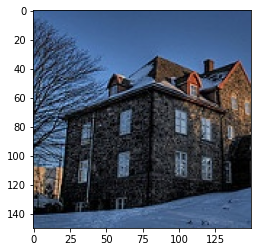

In [41]:
imshow(image_datasets['train'][8556][0])

In [50]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cpu_device

In [51]:
import torch.nn as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(50, 100, 3)
        self.relu1 = F.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(100, 50, 3)
        self.relu5 = F.ReLU()
        self.conv4 = nn.Conv2d(50, 50, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.relu6 = F.ReLU()
        self.fc1 = nn.Linear(50 * 15 * 15, 150)
        self.relu2 = F.ReLU()
        self.fc2 = nn.Linear(150, 84)
        self.relu3 = F.ReLU()
        self.fc3 = nn.Linear(84, 6)
        self.relu4 = F.ReLU()
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.relu1(self.pool2(self.conv2(x)))
        x = self.relu5(self.pool3(self.conv3(x)))
        x = self.relu6(self.conv4(x))
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        #x = x.view(16, -1, 6,  150)
        x = x.view(x.size(0), 50 * 15 * 15)
        x = self.relu2(self.fc1(x))
        x = self.relu3(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
ptr = Net()
ptr = ptr.to(device)

In [53]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [54]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)

In [55]:
import time
start = time.time()

In [56]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(5, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.225187560425529
Epoch 0, iteration 315 training_loss 1.0099954435342475
Epoch 0, iteration 473 training_loss 0.9394592473024055
Epoch 0, iteration 631 training_loss 0.8523424444130704
Epoch 0, iteration 789 training_loss 0.8042752120313765
Epoch 0, val_loss 0.8556976677341894, accuracy = 0.6566951566951567
Epoch 1, iteration 157 training_loss 0.7375968511723265
Epoch 1, iteration 315 training_loss 0.6889069421759134
Epoch 1, iteration 473 training_loss 0.6800428165853778
Epoch 1, iteration 631 training_loss 0.6607109244111218
Epoch 1, iteration 789 training_loss 0.6148415577562549
Epoch 1, val_loss 0.7607519147409634, accuracy = 0.7272079772079773
Epoch 2, iteration 157 training_loss 0.5560045503551447
Epoch 2, iteration 315 training_loss 0.5632742082205
Epoch 2, iteration 473 training_loss 0.5458138489836379
Epoch 2, iteration 631 training_loss 0.551511044838006
Epoch 2, iteration 789 training_loss 0.5151893088617657
Epoch 2, val_loss 0.489435186

In [57]:
from torchvision.utils import make_grid

In [58]:
xx, yy = next(iter(image_dataloaders['validation']))

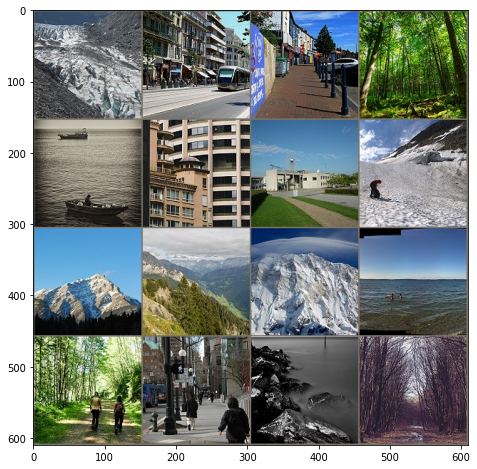

['glacier', 'street', 'buildings', 'forest', 'sea', 'buildings', 'buildings', 'glacier', 'mountain', 'mountain', 'glacier', 'sea', 'forest', 'street', 'sea', 'forest']
['glacier', 'street', 'street', 'forest', 'sea', 'buildings', 'buildings', 'glacier', 'mountain', 'mountain', 'mountain', 'sea', 'forest', 'street', 'sea', 'forest']


In [60]:
ptr.eval()
out = ptr(xx.cpu())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [61]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [62]:
from sklearn import metrics

In [63]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [64]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.82      0.83      0.82       437
      forest       0.95      0.96      0.95       474
     glacier       0.79      0.83      0.81       553
    mountain       0.79      0.80      0.79       525
         sea       0.85      0.83      0.84       510
      street       0.88      0.82      0.85       501

    accuracy                           0.84      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.84      0.84      0.84      3000



In [65]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,362,5,3,15,11,41
forest,1,455,2,8,2,6
glacier,4,4,457,56,29,3
mountain,3,3,75,422,22,0
sea,11,2,35,32,424,6
street,61,12,4,4,8,412
